In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yellowbrick.features.base import FeatureVisualizer
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.bestfit import draw_best_fit
from yellowbrick.utils import is_dataframe

class JointPlotVisualizer(FeatureVisualizer):
    def __init__(self, ax=None, feature=None, target=None, 
                 joint_plot='scatter', joint_args=None, 
                 xy_plot='hist', xy_args=None,
                 size=6, ratio=5, space=.2, **kwargs):
        
        """
        Initialize the visualization with many of the options required
        in order to make most visualizations work.

        These parameters can be influenced later on in the visualization
        process, but can and should be set as early as possible.

        Parameters
        ----------

        ax: This is inherited from FeatureVisualizer but is defined within
            JointPlotVisualizer since there are three axes objects.

        feature: The name of the X variable
            If a DataFrame is passed to fit and feature is None, featur
            is selected as the column of the DataFrame.  There must be only
            one column in the DataFrame.

        target: The name of the Y variable
            If target is None and a y value is passed to fit then the target
            is selected from the target vector.

        joint_plot: The type of plot to render in the joint axis.  Currently,
            the choices are scatter and hex.

        joint_args: Keyword arguments used for customizing the joint plot.
                Property        Description
                alpha           transparency
                facecolor       background color of the joint axis
                aspect          aspect ratio
                fit             used if scatter is selected for joint_plot to draw a 
                                best fit line - values can be True or False.
                                Uses Yellowbrick.bestfit
                estimator       used if scatter is selected for joint_plot to determine
                                the type of best fit line to use.  Refer to 
                                Yellowbrick.bestfit for types of estimators that can be used.
                x_bins          used if hex is selected to determine the number of bins for the x value
                y_bins          used if hex is selected to determine the number of bins for the y value
                cmap            string or matplotlib cmap to colorize lines
                                Use either color to colorize the lines on a per class basis or
                                colormap to color them on a continuous scale.
                
                
        xy_plot: The type of plot to render along the x and y axes.
            Currently, the choice is hist
            
        xy_args: Keyword arguments used for customizing the x and y plots.
                Property        Description
                alpha           transparency
                facecolor_x     background color of the x axis
                facecolor_y     background color of the y axis
                bins            used to set up the number of bins for the hist plot
                histcolor_x     used to set the color for the histogram on the x axis
                histcolor_y     used to set the color for the histogram on the y axis
                
        size: Size of each side of the figure in inches.
        
        ratio: Ratio of joint axis size to the x and y axes height.
        
        space: Space between the joint axis and the x and y axes.

        kwargs: Keyword arguments passed to the super class.

        """
            
        super(JointPlotVisualizer, self).__init__(ax, **kwargs)
        
        self.feature = feature
        self.target = target
        self.joint_plot = joint_plot
        self.joint_args = joint_args
        self.xy_plot = xy_plot
        self.xy_args = xy_args
        
        fig = plt.figure(figsize=(size, size))
        gs = plt.GridSpec(ratio + 1, ratio + 1)
        
        #Set up the 3 axes objects
        joint_ax = fig.add_subplot(gs[1:, :-1])
        x_ax = fig.add_subplot(gs[0, :-1], sharex=joint_ax)
        y_ax = fig.add_subplot(gs[1:, -1], sharey=joint_ax)
        
        fig.tight_layout()
        fig.subplots_adjust(hspace=space, wspace=space)
        
        self.fig = fig
        self.joint_ax = joint_ax
        self.x_ax = x_ax
        self.y_ax = y_ax
        
    
        plt.setp(self.x_ax.get_xticklabels(), visible=False)
        plt.setp(self.y_ax.get_yticklabels(), visible=False)

        plt.setp(self.x_ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(self.x_ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(self.y_ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(self.y_ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(self.x_ax.get_yticklabels(), visible=False)
        plt.setp(self.y_ax.get_xticklabels(), visible=False)
        self.x_ax.yaxis.grid(False)
        self.y_ax.xaxis.grid(False)
    
    def fit(self, X, y, **kwargs):
       
        #throw an error if X has more than 1 column
        if is_dataframe(X):
            nrows, ncols = X.shape
            if ncols > 1:
                raise YellowbrickValueError(
                "X cannot have more than 1 column"
                )   
            
        #throw an error is y is None
        if y is None:
            raise YellowbrickValueError(
                "y cannot be null")
        

        # Handle the feature name if it is None.
        if self.feature is None:

            # If X is a data frame, get the columns off it.
            if is_dataframe(X):
                self.feature = X.columns
            
            else:
                self.feature = ['x']

        # Handle the target name if it is None.
        if self.target is None:
            self.target = ['y']
            
        self.draw(X, y, **kwargs)
        return self
    
    
    def draw(self, X, y, **kwargs):     
        self.draw_joint(X, y, **kwargs)
        self.draw_xy(X, y, **kwargs)
              
    def draw_joint(self, X, y, **kwargs):
        if self.joint_args is None:
            self.joint_args = {}

        self.joint_args.setdefault("alpha", 0.4)
        facecolor = self.joint_args.pop("facecolor", "#dddddd")
        self.joint_ax.set_facecolor(facecolor)
        
        if self.joint_plot == "scatter":
            aspect = self.joint_args.pop("aspect", "auto")
            self.joint_ax.set_aspect(aspect)
            self.joint_ax.scatter(X, y, **self.joint_args)
        
            fit = self.joint_args.pop("fit", True)
            if fit:
                estimator = self.joint_args.pop("estimator", "linear")
                draw_best_fit(X, y, self.joint_ax, estimator)
                
        elif self.joint_plot == "hex":
            x_bins = self.joint_args.pop("x_bins", 50)
            y_bins = self.joint_args.pop("y_bins", 50)
            colormap = self.joint_args.pop("cmap", 'Blues')
            gridsize = int(np.mean([x_bins, y_bins]))
            
            xmin = X.min()
            xmax = X.max()
            ymin = y.min()
            ymax = y.max()
            
            self.joint_ax.hexbin(X, y, gridsize=gridsize, cmap=colormap, mincnt=1, **self.joint_args)
            self.joint_ax.axis([xmin, xmax, ymin, ymax])

    def draw_xy(self, X, y, **kwargs):
        if self.xy_args is None:
            self.xy_args = {}
        
        facecolor_x = self.xy_args.pop("facecolor_x", "#dddddd")
        self.x_ax.set_facecolor(facecolor_x)
        facecolor_y = self.xy_args.pop("facecolor_y", "#dddddd")
        self.y_ax.set_facecolor(facecolor_y)
        
        
        if self.xy_plot == "hist":
            hist_bins = self.xy_args.pop("bins", 50)
            self.xy_args.setdefault("alpha", 0.4)
            histcolor_x = self.xy_args.pop("histcolor_x", "#6897bb")
            self.x_ax.set_facecolor(facecolor_x)
            histcolor_y = self.xy_args.pop("histcolor_y", "#6897bb")
            self.y_ax.set_facecolor(facecolor_y)
            self.x_ax.hist(X, bins=hist_bins, color=histcolor_x, **self.xy_args)
            self.y_ax.hist(y, bins=hist_bins, color=histcolor_y, orientation='horizontal', **self.xy_args)
            
              
    def poof(self, **kwargs):
        self.joint_ax.set_xlabel(self.feature)
        self.joint_ax.set_ylabel(self.target)
        self.finalize(**kwargs)
        
    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        self.fig.suptitle("Joint Plot of {} vs {}"
                .format(self.feature, self.target), y=1.05)

In [5]:
import os
import sys  
import pandas as pd

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "credit": os.path.join(FIXTURES, "credit", "credit.csv"),
    "concrete": os.path.join(FIXTURES, "concrete", "concrete.csv"),
    "occupancy": os.path.join(FIXTURES, "occupancy", "occupancy.csv"),
}


def load_data(name):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
        
    # Return the data frame
    return pd.read_csv(path)

In [6]:
# Load the data
df = load_data('concrete')
features = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
feature = 'cement'
target = 'strength'
# Get the X and y data from the DataFrame 
X = df[feature].as_matrix()
y = df[target].as_matrix()

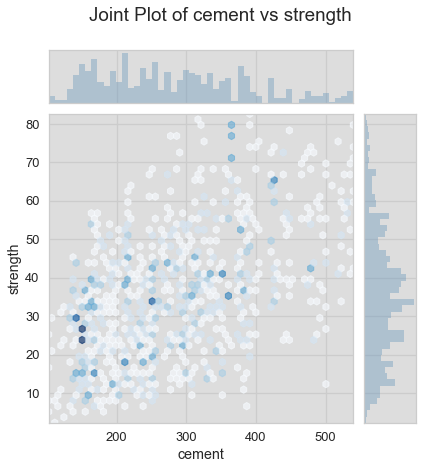

In [7]:
visualizer = JointPlotVisualizer(feature=feature, target=target, joint_plot="hex")
visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.draw_joint(X, y)
g = visualizer.poof()    # Draw/show/poof the data